In [2]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
from config import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from functools import reduce
from tqdm import tqdm

experiment = "KING_DEVICK"

df_event = pd.read_parquet(PREPROCESSED_DIR / f"{experiment}_events.pq").reset_index(drop=True)
df_sample = (pd.read_parquet(PREPROCESSED_DIR / f'{experiment}_samples.pq')
 .sort_values(["experiment", "participant_id", "trial_id","time"])
)

def rename_columns(df):
    """Renames columns by joining multi-level column names with different delimiters."""
    # Iterate over all column names
    df.columns = [f"{col[0]}" if col[1] == '' else f"{col[0]}_{col[1]}" for col in df.columns.values]
    return df



def load_demographic_info() -> pd.DataFrame:
    logging.info("Loading demographics")
    demographics = pd.read_excel(DATA_DIR / "demographic_info.xlsx")[["ID", "Group"]]

    demographics["y"] = (demographics["Group"] == "PATIENT").astype(int)
    demographics["participant_id"] = demographics["ID"].astype(int)
    demographics = demographics[["participant_id", "y"]]
    return demographics


def join_demographic_info_on_features(feature_df: pd.DataFrame) -> pd.DataFrame:
    logging.info("Joining demographics on features")
    demographics = load_demographic_info()
    return pd.merge(feature_df, demographics, how='left', on='participant_id')
    
    
    


# Event

In [3]:
def get_avg_mistakes_pr_trial(df: pd.DataFrame) -> pd.DataFrame:
    df = (df
          .query("event == 'TRIAL_VAR_DATA'")
          .groupby(["experiment", "participant_id"])
          .agg(avg_mistakes_pr_trial = ('marks', 'mean'))
          .reset_index()
    )
    return df
    
def get_avg_time_elapsed_pr_trial(df: pd.DataFrame) -> pd.DataFrame:
    df = (df
          .query("event == 'TRIAL_VAR_DATA'")
          .groupby(["experiment", "participant_id"])
          .agg(avg_time_elapsed_pr_trial = ('time_elapsed', 'mean'))
          .reset_index()
    )
    return df



def get_pre_calculated_metrics_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns pd.Dataframe with columns ['experiment','participant_id', X_FEATURES],
    where X_FEATURES is a collection of features found by the following cartesian product:
    {'peak_velocity', 'amplitude', 'duration', 'avg_pupil_size'} x {np.mean, np.min, np.max, np.median, np.std}
    """
    features_df = (df.groupby(["experiment", "participant_id"])
    .agg(
        mean_peak_velocity_sacc = ('peak_velocity', lambda x: x[df.loc[x.index, 'event'] == 'ESACC'].mean()),
        mean_amplitude_sacc = ('amplitude', lambda x: x[df.loc[x.index, 'event'] == 'ESACC'].mean()),
        mean_duration_sacc = ('duration', lambda x: x[df.loc[x.index, 'event'] == 'ESACC'].mean()),
        mean_duration_fix = ('duration', lambda x: x[df.loc[x.index, 'event'] == 'EFIX'].mean()),
        mean_pupil_size_fix = ('avg_pupil_size', lambda x: x[df.loc[x.index, 'event'] == 'EFIX'].mean()),
    )
    .reset_index()
    )    
    return features_df



In [ ]:

def king_devick_get_saccades_pr_second(df: pd.DataFrame) -> pd.DataFrame:
    logging.info("Adding saccades pr. second")
    df = (df
        .query("(eye == 'R') or (eye.isnull())") # right eye or is na
        .sort_values(by=["participant_id", "trial_id","time"])
        .assign(stimulus_time = lambda x: np.select([x.event == "FIXPOINT", x.event != "FIXPOINT"], [x.time, None]))
        .assign(stimulus_time = lambda x: x["stimulus_time"].ffill())
        .assign(trial_active_duration_seconds = lambda x: (
                x.sort_values(by=["participant_id", "trial_id", "time"])
                .groupby(["participant_id", "trial_id"])["time_elapsed"]
                .transform(lambda group: (
                    group.iloc[0]
                ))
            ))
        .query("event == 'ESACC'")
        .groupby(["experiment", "participant_id", "trial_id", "trial_active_duration_seconds"])
        .size()
        .reset_index(name="n_saccades")
        .assign(fixations_per_second=lambda x: x["n_saccades"] / x["trial_active_duration_seconds"])
        .groupby(["experiment", "participant_id"])
        .agg(avg_saccades_pr_second = ('fixations_per_second', 'mean'),
             std_saccades_pr_second = ('fixations_per_second', 'std'),
             median_saccades_pr_second = ('fixations_per_second', 'median'))
        .reset_index()
    )
    return df

In [6]:
king_devick_get_saccades_pr_second(df_event)

2025-04-25 14:12:26,275 - INFO - 3811458135.king_devick_get_saccades_pr_second:2 - Adding saccades pr. second


,experiment,participant_id,avg_saccades_pr_second,std_saccades_pr_second,median_saccades_pr_second
0,KING_DEVICK,106,4.337388,0.324815,4.506045
1,KING_DEVICK,111,4.723797,0.577230,4.378805
2,KING_DEVICK,113,5.003001,0.704765,4.836188
3,KING_DEVICK,121,4.735075,0.738907,4.349588
4,KING_DEVICK,122,4.833018,0.794919,4.589149
...,...,...,...,...,...
164,KING_DEVICK,399,4.394645,0.270889,4.300616
165,KING_DEVICK,401,3.603361,0.230947,3.578792
166,KING_DEVICK,402,3.497259,0.234884,3.479496
167,KING_DEVICK,403,4.277674,0.304482,4.176711


2025-04-25 13:40:42,352 - INFO - 3081433536.king_devick_get_saccades_pr_second:2 - Adding saccades pr. second
2025-04-25 13:40:42,430 - INFO - 2345115736.join_demographic_info_on_features:39 - Joining demographics on features
2025-04-25 13:40:42,431 - INFO - 2345115736.load_demographic_info:29 - Loading demographics


<Axes: xlabel='std_saccades_pr_second', ylabel='Density'>

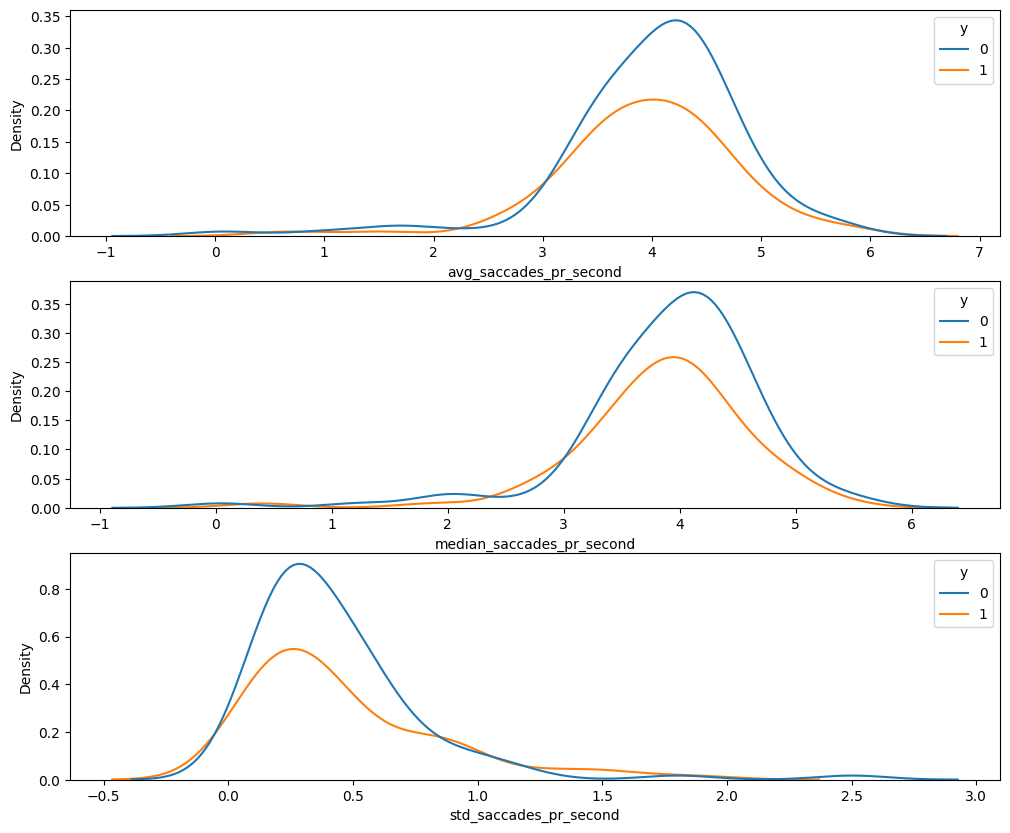

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
data=join_demographic_info_on_features(king_devick_get_saccades_pr_second(df_event))

fig, ax = plt.subplots(nrows=3, figsize=(12,10))
sns.kdeplot(data=data, x='avg_saccades_pr_second', hue='y', ax= ax[0])
sns.kdeplot(data=data, x='median_saccades_pr_second', hue='y', ax= ax[1])
sns.kdeplot(data=data, x='std_saccades_pr_second', hue='y', ax= ax[2])


In [62]:

def king_devick_get_pct_wrong_directional_saccades(df: pd.DataFrame) -> pd.DataFrame:
    def add_total_trials(df:pd.DataFrame) -> pd.DataFrame:
        return (df
                .groupby(["experiment", "participant_id", "trial_id"])
                .transform(lambda group: len(group))
                )
    
    
    logging.info("Adding saccades pr. second")
    df = (df
        .query("(eye == 'R') or (eye.isnull())") # right eye or is na
        .sort_values(by=["participant_id", "trial_id","time"])
        .assign(stimulus_time = lambda x: np.select([x.event == "FIXPOINT", x.event != "FIXPOINT"], [x.time, None]))
        .assign(stimulus_time = lambda x: x["stimulus_time"].ffill())
        .assign(saccade_direction = lambda x: np.select([
                                                        (x["event"] == 'ESACC') & (x["end_x"] > x["start_x"]),
                                                        (x["event"] == 'ESACC') & (x["end_x"] < x["start_x"])],
                                                        ["right", "left"], default=None))
        .query("event == 'ESACC'")
        .groupby(["experiment", "participant_id", "trial_id", "saccade_direction"])
        .size()
        .reset_index(name="n_saccades")
        .assign(n_trial_saccades = lambda x: (x
            .groupby(["participant_id", "trial_id"])["n_saccades"]
            .transform(lambda group: (
                    group.sum()
                ))
            ))
        .assign(pct_saccade = lambda x: 100* x["n_saccades"] / x["n_trial_saccades"])
        .query("saccade_direction == 'left'")
        .groupby(["experiment", "participant_id"])
        .agg(
            avg_wrong_direction_saccade_pct = ('pct_saccade', 'mean'),
            std_wrong_direction_saccade_pct = ('pct_saccade', 'std')
        )
        .reset_index()
    )
    return df





2025-04-25 14:07:46,787 - INFO - 1659598320.king_devick_get_pct_wrong_directional_saccades:9 - Adding saccades pr. second
2025-04-25 14:07:46,867 - INFO - 2345115736.join_demographic_info_on_features:39 - Joining demographics on features
2025-04-25 14:07:46,868 - INFO - 2345115736.load_demographic_info:29 - Loading demographics


<Axes: xlabel='std_wrong_direction_saccade_pct', ylabel='Density'>

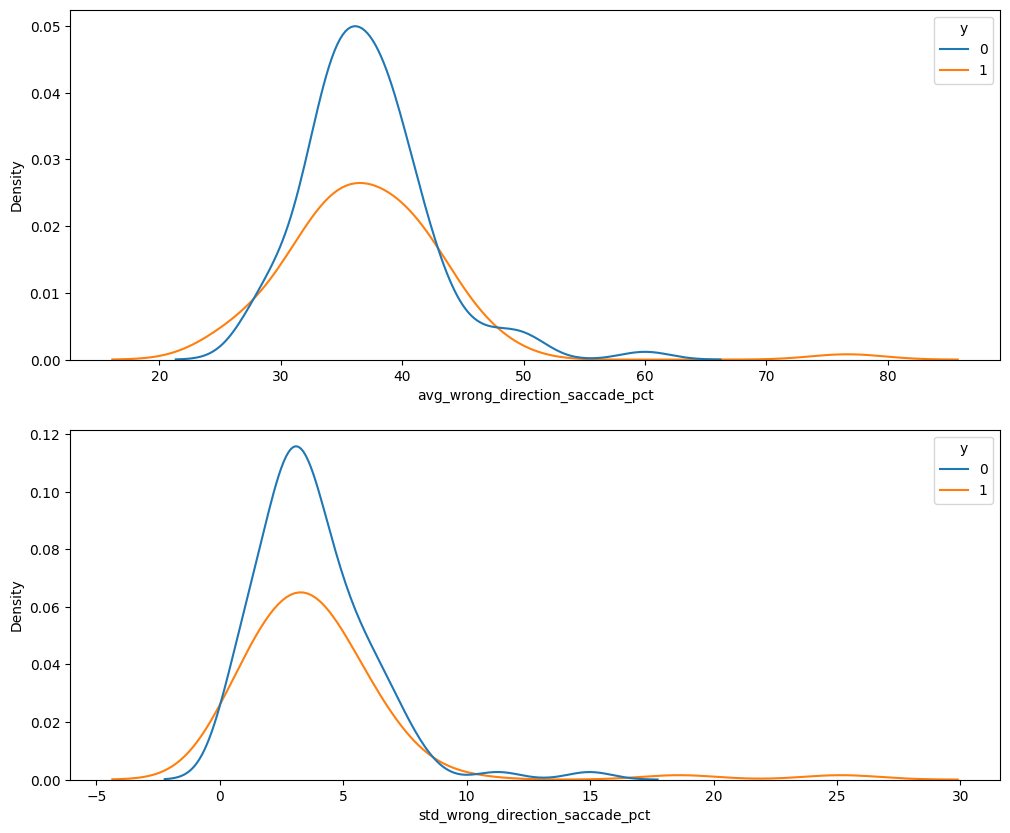

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
data=join_demographic_info_on_features(king_devick_get_pct_wrong_directional_saccades(df_event))

fig, ax = plt.subplots(nrows=2, figsize=(12,10))
sns.kdeplot(data=data, x='avg_wrong_direction_saccade_pct', hue='y', ax= ax[0])
sns.kdeplot(data=data, x='std_wrong_direction_saccade_pct', hue='y', ax= ax[1])


# Sample

In [23]:
def get_acceleration_feature(df: pd.DataFrame) -> pd.DataFrame:
    """Finds acceleration features for anti saccade experiment

    Args:
        df (pd.DataFrame): Dataframe with raw samples

    Returns:
        pd.DataFrame: Dataframe with columns ['experiment','participant_id', X_FEATURES]
        where X_FEATURES is a collection of features found by the following cartesian product:
        {'total_acceleration_magnitude_left', 'total_acceleration_magnitude_right'} x {np.mean, np.min, np.max, np.median, np.std}
    """
    logging.info("Extracting acceleration")
    acceleration = (df.join((df
    .groupby(["experiment", "participant_id", "trial_id"])[['x_velocity_left', 'y_velocity_left', 'x_velocity_right', 'y_velocity_right']].shift(1)
    .rename(columns={'x_velocity_left': 'x_velocity_left_lagged'
            , 'y_velocity_left': 'y_velocity_left_lagged'
            , 'x_velocity_right': 'x_velocity_right_lagged'
            , 'y_velocity_right': 'y_velocity_right_lagged'}))
    ).assign(x_acceleration_left = lambda x: (x["x_velocity_left"] - x["x_velocity_left_lagged"]) / (1/2000),
            y_acceleration_left = lambda x: (x["y_velocity_left"] - x["y_velocity_left_lagged"]) / (1/2000),
            x_acceleration_right = lambda x: (x["x_velocity_right"] - x["x_velocity_right_lagged"]) / (1/2000),
            y_acceleration_right = lambda x: (x["y_velocity_right"] - x["y_velocity_right_lagged"]) / (1/2000))
    .assign(total_acceleration_magnitude_left = lambda x: np.sqrt( np.power(x["x_acceleration_left"], 2) + np.power(x["y_acceleration_left"], 2)),
            total_acceleration_magnitude_right = lambda x: np.sqrt( np.power(x["x_acceleration_right"], 2) + np.power(x["y_acceleration_right"], 2)))
    .groupby(["experiment", "participant_id"])
    .agg({'total_acceleration_magnitude_left': [np.mean, np.min, np.max, np.median, np.std],
        'total_acceleration_magnitude_right': [np.mean, np.min, np.max, np.median, np.std]
        })
    .reset_index()
    .pipe(rename_columns)
    )
    return acceleration


# Eye disconjugacy
# Paper: https://www.liebertpub.com/doi/full/10.1089/neu.2014.3687

def get_disconjugacy_feature(df:pd.DataFrame) -> pd.DataFrame:
    logging.info("Extracting disconjugacy")
    disconjugacy = (df
        .sort_values(["experiment", "participant_id", "trial_id", "time"])
        .query("x_left == x_left & x_right == x_right & y_left == y_left & y_right == y_right") # same as not null
        .groupby(["experiment", "participant_id"])
        .apply(lambda group: group.assign(
            x_left_rolling=group["x_left"].rolling(window=5, min_periods=1).mean(),
            x_right_rolling=group["x_right"].rolling(window=5, min_periods=1).mean(),
            y_left_rolling=group["y_left"].rolling(window=5, min_periods=1).mean(),
            y_right_rolling=group["y_right"].rolling(window=5, min_periods=1).mean()
        ))
        .reset_index(drop=True)
        .assign(
            X_diffs = lambda x: ((x["x_left_rolling"] - x["x_right_rolling"]) - 0)**2,
            Y_diffs = lambda x: ((x["y_left_rolling"] - x["y_right_rolling"]) - 0)**2
        )
        .groupby(["experiment", "participant_id"])
        .apply(lambda group: group.assign(
            X_squared_scaled = group["X_diffs"] / group.shape[0],
            Y_squared_scaled = group["Y_diffs"] / group.shape[0]
        ))
        .reset_index(drop=True)
        .groupby(["experiment", "participant_id"])
        .agg(
            Var_X = ("X_squared_scaled", "sum"),
            Var_Y = ("Y_squared_scaled", "sum")
        )
        .assign(
            Var_total = lambda x: x["Var_X"] + x["Var_Y"]
        )
        .reset_index()
        [["experiment", "participant_id", "Var_total"]]
    )
    return disconjugacy



# Combining

In [24]:
def get_king_devick_features(df_event: pd.DataFrame, df_sample:pd.DataFrame) -> pd.DataFrame:
    """Runs all king devick features extractions

    Args:
        df (pd.DataFrame): The preprocessed dataframe

    Returns:
        pd.DataFrame: Dataframe with columns ["experiment", "participant_id", X_FEATURES], where X_FEATURES is a collection of features
    """
    logging.info("Starting fitts law feature extraction")
    
    logging.info("Starting event feature extraction")
    event_feature_functions = [get_avg_mistakes_pr_trial, get_avg_time_elapsed_pr_trial, get_pre_calculated_metrics_feature]
    df_event_features_list = [f(df=df_event) for f in event_feature_functions]
    
    logging.info("Starting sample feature extraction")
    sample_feature_functions = [get_acceleration_feature, get_disconjugacy_feature]
    df_sample_features_list = [f(df=df_sample) for f in sample_feature_functions]
    
    df_features_list = df_event_features_list + df_sample_features_list
    
    df_features = reduce(lambda x, y: pd.merge(x, y, on = ["experiment", "participant_id"]), df_features_list)
    
    return df_features


features = get_king_devick_features(df_event=df_event, df_sample=df_sample)
    

    

2025-04-16 16:25:14,236 - INFO - 2866491546.get_king_devick_features:10 - Starting fitts law feature extraction
2025-04-16 16:25:14,238 - INFO - 2866491546.get_king_devick_features:12 - Starting event feature extraction
2025-04-16 16:25:14,456 - INFO - 2866491546.get_king_devick_features:16 - Starting sample feature extraction
2025-04-16 16:25:14,456 - INFO - 615019999.get_acceleration_feature:12 - Extracting acceleration
2025-04-16 16:25:30,490 - INFO - 615019999.get_disconjugacy_feature:39 - Extracting disconjugacy
/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_74155/615019999.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.assign(
/var/folders/v0/l_d

# Save

In [25]:
features.to_parquet(FEATURES_DIR / f"{experiment}_features.pq")
